# IS5152 Project: News Headlines Dataset For Sarcasm Detection


### Objective
Given a news headline, predict whether a news headline is a sarcastic remark or not. We used unsupervised and supervised learning methods, such as Latent Dirichlet Allocation for topic extraction and Deep Learning models (CNN, LSTM with pre-trained word embeddings and self-trained word embeddings) for prediction of sarcasm in news headline. 

---

### Context
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

- Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

- Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

- Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

---

### Content
Each record consists of three attributes:

`is_sarcastic` : 1 if the record is sarcastic otherwise 0

`headline`     : the headline of the news article

`article_link`: link to the original news article. Useful in collecting supplementary data

---

### Motivation
Given the rise of fake news on social media as well as on news outlets, it is important for people to identify sarcastic news reports from legitimate news reports. This will allow people to know when to take the news at face value and not spread false rumours.

### Table of Contents

* [ Exploratory Data Analysis and Data Processing ](#EDA)

* [ Identifying Topics in dataset via LDA ](#LDA)

* [ Prediction via Deep Learning Methods](#deeplearning)
    * [ RNN with GRU ](#gru)
    * [ RNN with LSTM ](#lstm)
    * [ CNN with Conv1D ](#cnn)
    * [ Combined Architecture of CNN with RNN ](#cnnrnn)

All models are trained with Regularization, Dropout layer and Batch Normalization to stabilize and improve the performance of the models.

In [1]:
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

print(tf.__version__)  # 2.0.0-beta0

2.0.0-beta0


In [2]:
# Run this code for the first time, to install the libraries and download wordnet
# %reset
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install gensim
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
df = pd.read_json("news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
df = df[['headline', 'is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


<a name="EDA"></a>
### Exploratory Data Analysis

We would first like to understand the news headline dataset and identify the factors that causes a headline to be sarcastic news report. We would also like to identify if there is an imbalanced class, the frequencies and distribution of the different type of words. This will enable us to know if additional data processing steps are required (e.g. sampling of datapoints from sarcastic class if there is an imbalanced class in the dataset)  

Data processing steps: 
- Check for missing values in headline, is_sarcastic
- Convert all words into lowercase 
- Check for imbalanced classes in dataset
- Removal of punctuation

Some questions we would like to investigate:
- What are the frequencies of sarcastic headlines against the non-sarcastic headlines?
- What is the word length of headlines? For sarcastic and non-sarcastic headlines?
- Does the sarcastic headlines uses statistics (digits/numbers) in their wording? Compared to non-sarcastic headlines?
- Topic Modelling. What are the topics in news headline for entire/sarcastic/non-sarcastic datasets?
- What are all the topics in the news headline? Most popular topic?
- What are all the topics involved in the news headline which are sarcastic? Most popular topic?
- What are all the topics involved in the news headline which are not sarcastic? Most popular topic?

In [4]:
# check for columns with null values
df.is_sarcastic.isnull().any() # no missing values in is_sarcastic column
df.headline.isnull().any() # no missing values in headline column

False

In [5]:
df['headline'] = df.headline.apply(lambda x:x.lower())  # convert all words in headline into lower case 
df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuations in headline

In [7]:
df['headline_count'] = df.headline.apply(lambda x: len(list(x.split())))
df['headline_unique_word_count'] = df.headline.apply(lambda x: len(set(x.split())))
df['headline_has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))
df

,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits
0,former versace store clerk sues over secret bl...,0,12,12,False
1,the roseanne revival catches up to our thorny ...,0,14,14,False
2,mom starting to fear son's web series closest ...,1,14,13,False
3,boehner just wants wife to listen not come up ...,1,13,13,False
4,j.k rowling wishes snape happy birthday in the...,0,11,11,False
...,...,...,...,...,...
26704,american politics in moral free-fall,0,5,5,False
26705,america's best 20 hikes,0,4,4,True
26706,reparations and obama,0,3,3,False
26707,israeli ban targeting boycott supporters raise...,0,8,8,False


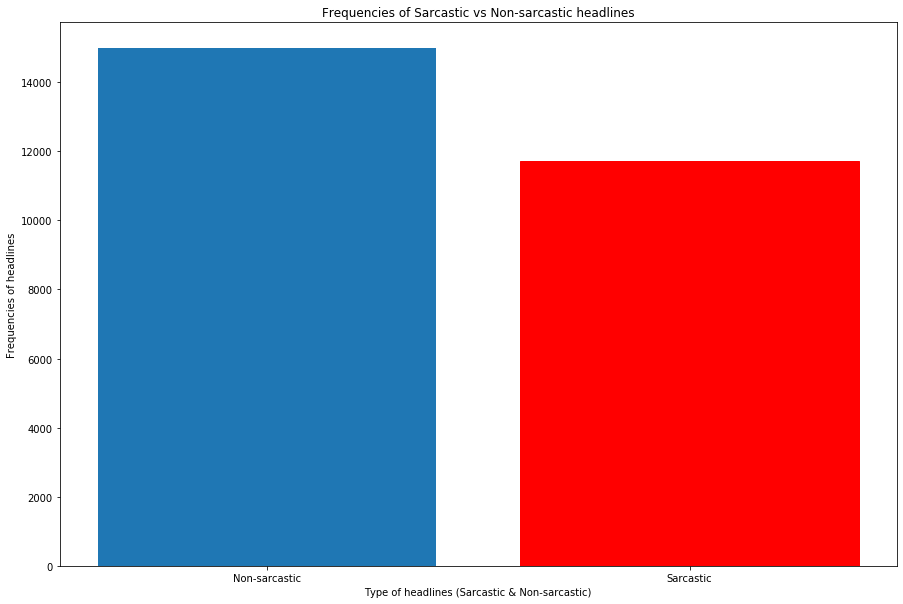

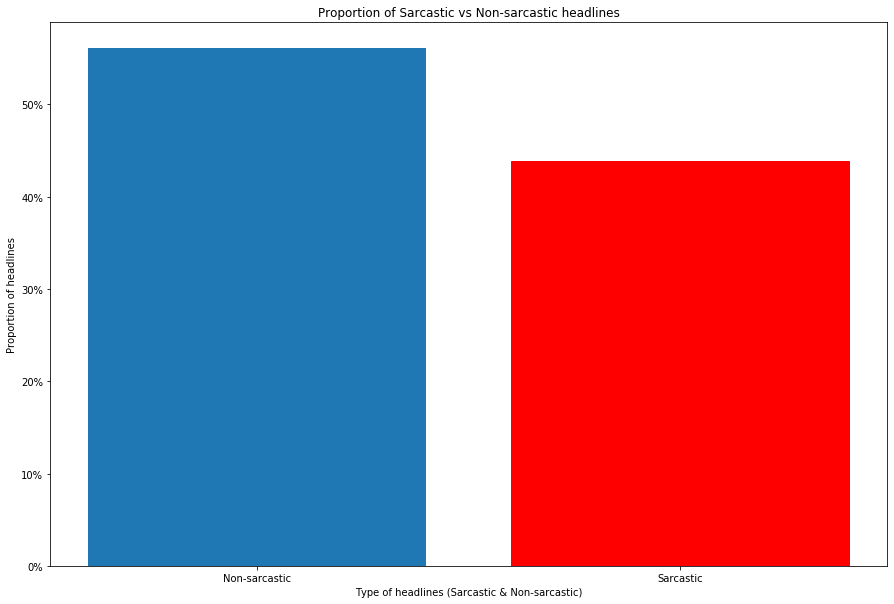

Non-sarcastic    0.56
Sarcastic        0.44
Name: headline_count, dtype: float64

In [8]:
sarcastic_dat = df.groupby('is_sarcastic').count()
sarcastic_dat.index = ['Non-sarcastic','Sarcastic']
plt.figure(figsize=(15, 10))
plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count)
bar_graph[1].set_color('r')
plt.show()


plt.figure(figsize=(15, 10))
plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Proportion of headlines')
plt.xticks(fontsize=10)
plt.title('Proportion of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# This is not an imbalanced class dataset
# Non-sarcastic    0.56
# Sarcastic        0.44
round(sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum(), 2)

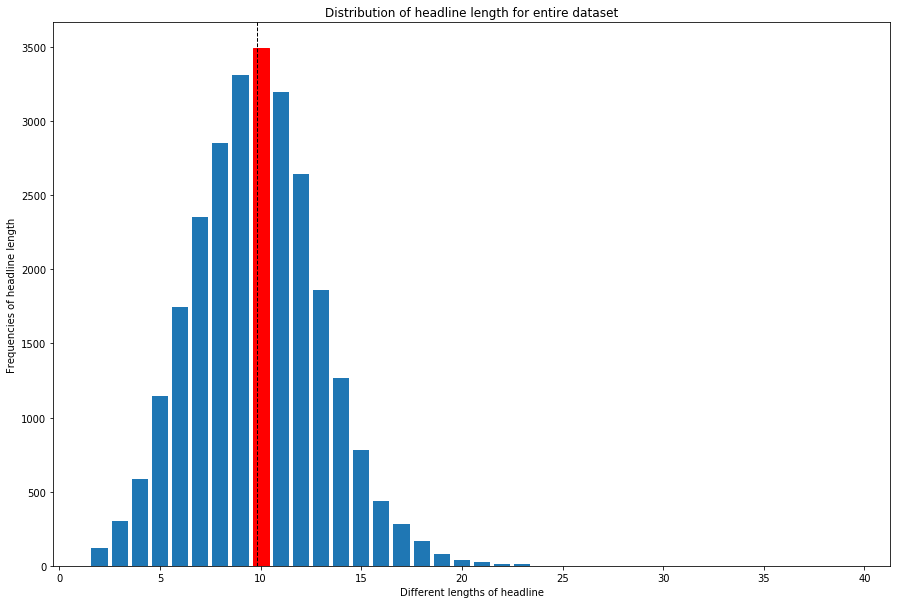

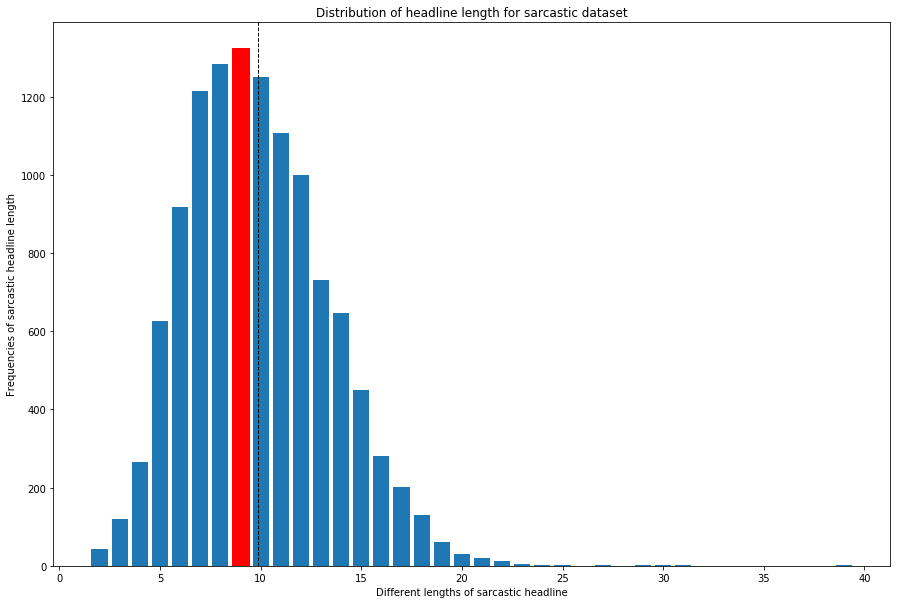

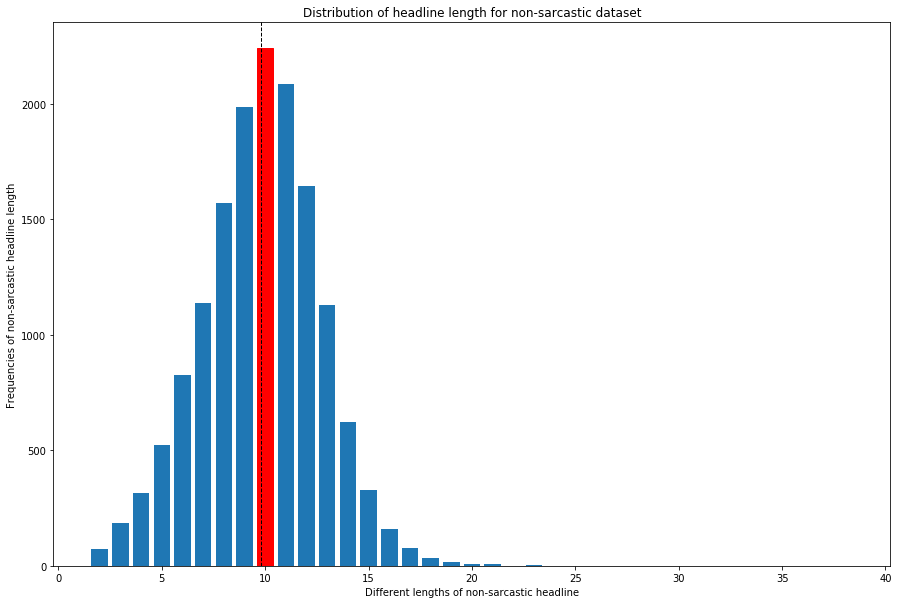

In [9]:
all_dat = df.groupby('headline_count').count()
sarcastic_dat1 = df[df.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('headline_count').count()
not_sarcastic_dat1 = df[df.is_sarcastic==0]
not_sarcastic_dat = not_sarcastic_dat1.groupby('headline_count').count()

plt.figure(figsize=(15, 10))
plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for entire dataset')
bar_graph = plt.bar(all_dat.index, all_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(df.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

plt.figure(figsize=(15, 10))
plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for sarcastic dataset')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
bar_graph[7].set_color('r')
plt.axvline(sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

plt.figure(figsize=(15, 10))
plt.xlabel('Different lengths of non-sarcastic headline')
plt.ylabel('Frequencies of non-sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for non-sarcastic dataset')
bar_graph = plt.bar(not_sarcastic_dat.index, not_sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(not_sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

# difference in the length of sarcastic and non-sarcastic headlines is not significant. 
# median and mean length of headlines is around 10 words

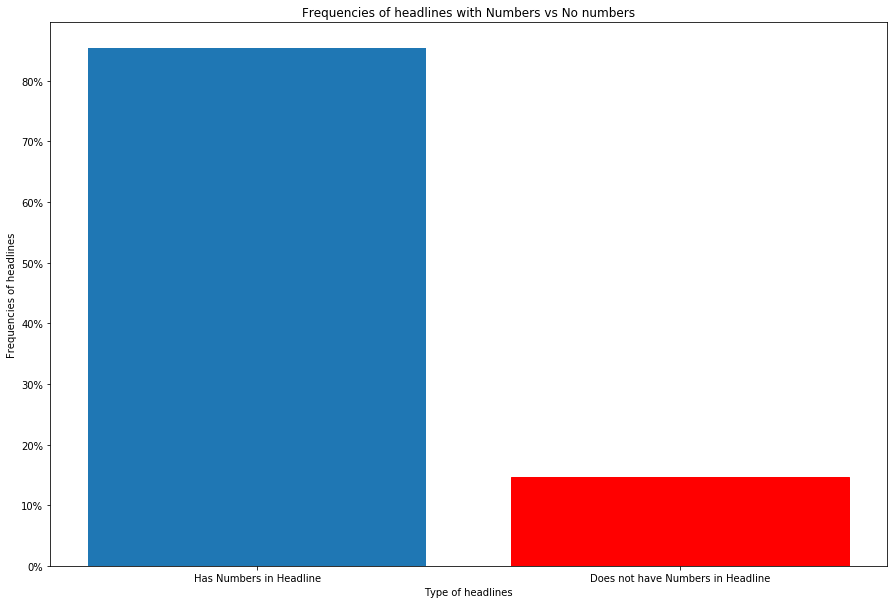

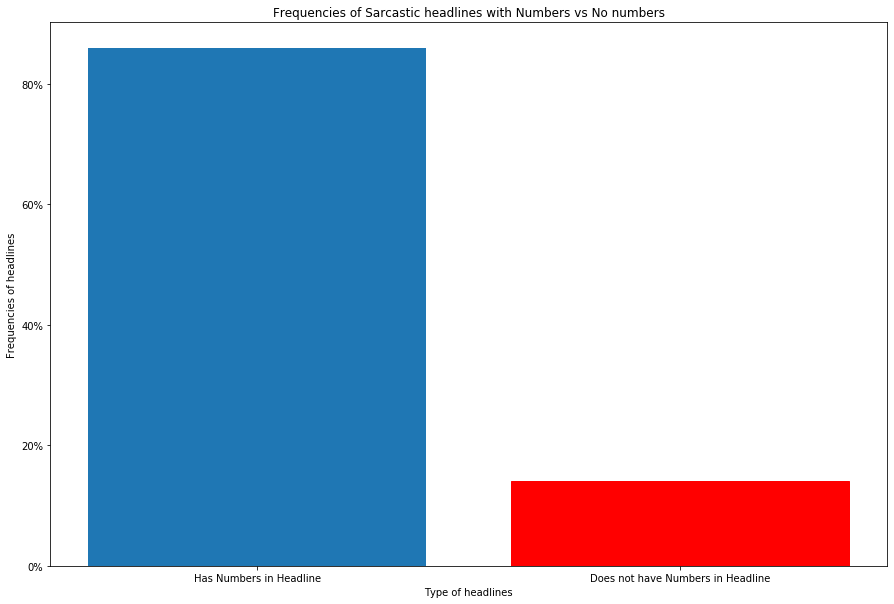

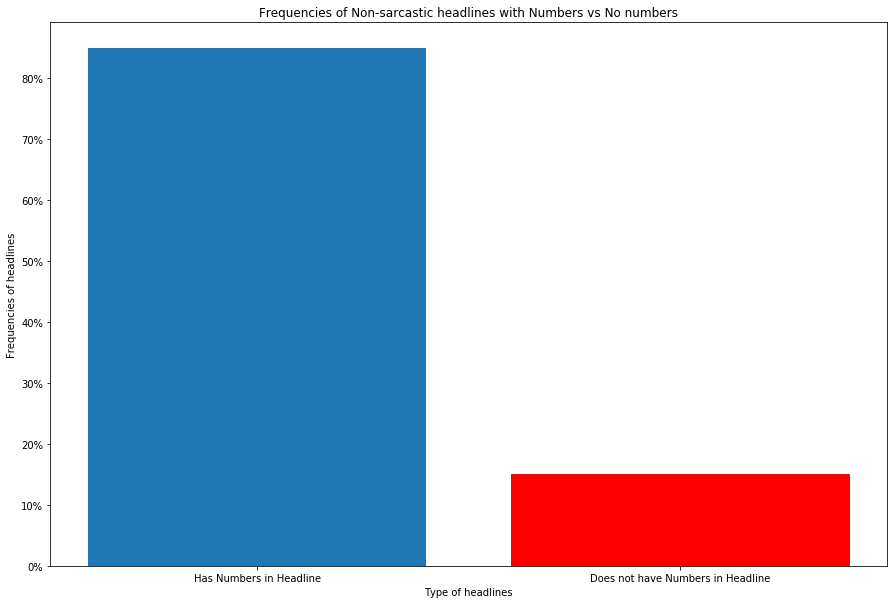

Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64
Has Numbers in Headline              0.86
Does not have Numbers in Headline    0.14
Name: headline, dtype: float64
Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64


In [10]:
digits_dat = df.groupby('headline_has_digits').count()
digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']

plt.figure(figsize=(15, 10))
plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of headlines with Numbers vs No numbers')
bar_graph = plt.bar(digits_dat.index, digits_dat.headline / digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


sarcastic_digits_dat = df[df.is_sarcastic==1].groupby('headline_has_digits').count()
sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']

plt.figure(figsize=(15, 10))
plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(sarcastic_digits_dat.index, sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


not_sarcastic_digits_dat = df[df.is_sarcastic==0].groupby('headline_has_digits').count()
not_sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']

plt.figure(figsize=(15, 10))
plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Non-sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(not_sarcastic_digits_dat.index, not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

print(round(digits_dat.headline / digits_dat.headline_count.sum(),2))
print(round(sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum(),2))
print(round(not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum(),2))

# difference in the use of numbers/statistics in sarcastic and non-sarcastic headlines is not significant. 
# ~85% headlines uses numbers

<a name="LDA"></a>
### Identifying Topics in dataset via LDA

#### Background
LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words. LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. LDA assumes that each document (i.e. headline) consists of a mixture of topics (multinomial distribution) and each topic consists of a mixture of words (multinomial distribution).

### Parameters
LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic.
There are 3 main parameters of the model:
- the number of topics
- the number of words per topic
- the number of topics per document

### Data processing
Before we can perform LDA, we will need to process the text in the following steps:

- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Removal of stop words.
- Removing Headlines that contains very few words. This helps to reduce the likelihood of headlines (that comprise of very but commonly-used words) matching together.  
- Lemmatization: words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Stemming: words are reduced to their root form.

Whilst labelling each clusters give us an intuition of the meaning of each cluster,
it is not necessary as the goal is not to label each document/headline into a cluster, but to measure the similarity between 2 documents/headlines.
We can do so simply using similarity measures like Jensen-Shanon distance matric.

### Limitations
- Need to pre-specify number of topics/clusters in advance. 
- Heuristics to determine the optimal number of topics/clusters is largely based on domain knowledge and human interpretability.
- Cannot capture correlations between topics/clusters.

In [37]:
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))


def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [38]:
text_data = []
for headline in df.headline:
    tokens = prepare_text_for_lda(headline)
    text_data.append(tokens)

In [41]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus

In [42]:
import gensim

NUM_TOPICS = [3, 5, 10]
# passes: Number of passes through the corpus during training
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.
# we do not alter / fine tune the default values of alpha and beta
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS[1], id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.013*"school" + 0.009*"parent" + 0.007*"student" + 0.007*"woman" + 0.005*"child"'),
 (1,
  '0.022*"trump" + 0.010*"clinton" + 0.009*"right" + 0.007*"campaign" + 0.007*"first"'),
 (2,
  '0.016*"woman" + 0.011*"report" + 0.008*"american" + 0.007*"study" + 0.006*"find"'),
 (3,
  '0.005*"photo" + 0.005*"season" + 0.005*"father" + 0.004*"release" + 0.004*"mother"'),
 (4,
  '0.029*"trump" + 0.012*"house" + 0.010*"white" + 0.009*"donald" + 0.008*"obama"')]

In [43]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.012*"woman" + 0.009*"people" + 0.008*"world" + 0.006*"clinton" + 0.006*"change"'),
 (1,
  '0.006*"child" + 0.006*"state" + 0.005*"school" + 0.005*"parent" + 0.004*"health"'),
 (2,
  '0.031*"trump" + 0.009*"donald" + 0.007*"house" + 0.007*"american" + 0.006*"white"')]

In [44]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.024*"school" + 0.014*"student" + 0.012*"death" + 0.011*"health" + 0.011*"month"'),
 (1,
  '0.086*"trump" + 0.031*"donald" + 0.012*"nation" + 0.011*"attack" + 0.010*"campaign"'),
 (2,
  '0.024*"house" + 0.020*"white" + 0.014*"study" + 0.013*"people" + 0.012*"find"'),
 (3,
  '0.018*"things" + 0.016*"court" + 0.014*"every" + 0.013*"movie" + 0.011*"supreme"'),
 (4,
  '0.016*"election" + 0.014*"republican" + 0.014*"going" + 0.013*"world" + 0.011*"candidate"'),
 (5,
  '0.021*"trump" + 0.015*"woman" + 0.014*"think" + 0.010*"medium" + 0.009*"single"'),
 (6,
  '0.022*"child" + 0.011*"money" + 0.011*"thing" + 0.010*"reason" + 0.010*"congress"'),
 (7,
  '0.030*"obama" + 0.018*"watch" + 0.012*"parent" + 0.012*"story" + 0.011*"announce"'),
 (8,
  '0.023*"clinton" + 0.016*"first" + 0.016*"american" + 0.013*"release" + 0.013*"hillary"'),
 (9,
  '0.023*"change" + 0.010*"climate" + 0.008*"former" + 0.008*"try" + 0.007*"second"')]

In [45]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\John\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [46]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

C:\Users\John\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [47]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)

C:\Users\John\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [48]:
from numpy import mean

sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda10[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 10 clusters:')
print('\nFor Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda10[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 10 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 10 clusters:

For Sarcastic Dataset:
[(0, 0.012498019), (1, 0.12197406), (2, 0.17721885), (3, 0.08259081), (4, 0.012496955), (5, 0.12230998), (6, 0.012496736), (7, 0.22301993), (8, 0.08261609), (9, 0.15277854)]

For Non-sarcastic Dataset:
[(0, 0.012502115), (1, 0.15242858), (2, 0.22304028), (3, 0.067341484), (4, 0.01250139), (5, 0.15285788), (6, 0.012501111), (7, 0.17721073), (8, 0.067361265), (9, 0.122255124)]


In [49]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 5 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 5 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 5 clusters:
For Sarcastic Dataset:
[(0, 0.1804386), (1, 0.107236974), (2, 0.2138662), (3, 0.4746743), (4, 0.023783991)]

For Non-sarcastic Dataset:
[(0, 0.14665832), (1, 0.13078569), (2, 0.267049), (3, 0.4314106), (4, 0.02409635)]


In [50]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda3[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 3 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda3[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 3 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 3 clusters:
For Sarcastic Dataset:
[(0, 0.44040143), (1, 0.14399174), (2, 0.4156069)]

For Non-sarcastic Dataset:
[(0, 0.40809196), (1, 0.121761024), (2, 0.470147)]


### Conclusion of insights from EDA:
- What are the frequencies of sarcastic headlines against the non-sarcastic headlines?


<span style="color:blue"> This is not an imbalanced class dataset. 56% of the headlines are non-sarcastic and 44% of the headlines are sarcastic. Hence, there is no requirements for conduct sampling to ensure an equal proportion of datasets from each class. </span>


- What is the word length of headlines? For sarcastic and non-sarcastic headlines?


<span style="color:blue"> In the entire dataset, the mean and median length of headlines is around 10 words. There are some headlines with 2 / 3 / 4 words. These headlines need to be removed as they are too short. Short headlines will have a higher likelihood of being similar to other headlines without providing meaningful information in the topics.

There is no significant difference in the length of headlines for sarcastic and non-sarcastic datatset. </span>


- Does the sarcastic headlines uses statistics (digits/numbers) in their wording? Compared to non-sarcastic headlines?


<span style="color:blue"> In the entire dataset, 85% of all the headlines uses numbers. There is no significant difference in the use of numbers for sarcastic and non-sarcastic datatset. This suggests that most headlines uses numbers to attract viewership. </span>

- Topic Modelling. What are the topics in news headline for entire/sarcastic/non-sarcastic datasets?

- What are all the topics in the news headline? Most popular topic?


<span style="color:blue"> For topic modelling, based on the dataset, the higher the number of topics, the more specialized the topics become. We have performed pre-processing of the data and subsequently applied LDA to create 3 / 5 / 10 topics. LDA for 10 topics helps us to understand the topics better. For example, for LDA10, topic 8 is generally about social media. Topic 9 is about politicians, namely Donald Trump. Topic 2 is about children, violence, climate change. 
For sarcastic and non-sarcastic datasets, the ratio of topics seems to be similar and there is no significant difference. The sizes of each topic is also similar. All these information suggests that sarcastic headlines is pervasive and appears throughout different genres of news.</span>

- What are all the topics involved in the news headline which are sarcastic? Most popular topic?
- What are all the topics involved in the news headline which are not sarcastic? Most popular topic?


<a name="deeplearning"></a>
### Prediction of Sarcasm in headlines using Deep Learning methods

For the prediction of sarcasm of headlines, we will use RNN with the following architectures:

- RNN with Gated Recurrent Units (with Lasso Regularization, Dropout, Batch Normalization)
- RNN with Gated Recurrent Units (with Ridge Regularization, Dropout, Batch Normalization)
- RNN with Long Short Term Memory Units (with Lasso Regularization, Dropout, Batch Normalization)
- RNN with Long Short Term Memory Units (with Ridge Regularization, Dropout, Batch Normalization)
- CNN with Conv1D
- Combination of CNN-RNN (LSTM)
    - Output from CNN with Conv1D is used as input for RNN with LSTM (with Lasso Regularization, Dropout, Batch Normalization)

<a name="gru"></a>
#### RNN with GRU

In [62]:
train_data, test_data = train_test_split(df[['headline', 'is_sarcastic']], test_size=0.1)  # randomly splitting 10% of dataset to be training dataset 

training_sentences = list(train_data['headline'])
training_labels = list(train_data['is_sarcastic'])

testing_sentences = list(test_data['headline'])
testing_labels = list(test_data['is_sarcastic'])
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [63]:
vocab_size = 10000   # limit vector of words to the top 10,000 words
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# no lemmatization, removal of stop words and stemming of headlines as we would like to maintain the syntax, literature integrity, sequence of words in LSTM.

In [64]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [89]:
# Model Definition with BiRNN (GRU)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_18 (Dense)             (None, 100)               6500      
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 176,601
Trainable params: 176,401
Non-trainable params: 200
______________________________________________

In [90]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 24038 samples, validate on 2671 samples
Epoch 1/10
11776/24038 [=============>................] - ETA: 4:19 - loss: 2.5561 - accuracy: 0.50 - ETA: 2:28 - loss: 2.5643 - accuracy: 0.51 - ETA: 1:50 - loss: 2.5575 - accuracy: 0.52 - ETA: 1:31 - loss: 2.5555 - accuracy: 0.48 - ETA: 1:19 - loss: 2.5468 - accuracy: 0.48 - ETA: 1:10 - loss: 2.5398 - accuracy: 0.47 - ETA: 1:05 - loss: 2.5251 - accuracy: 0.50 - ETA: 1:01 - loss: 2.5192 - accuracy: 0.50 - ETA: 58s - loss: 2.5112 - accuracy: 0.5035 - ETA: 55s - loss: 2.4990 - accuracy: 0.517 - ETA: 53s - loss: 2.4939 - accuracy: 0.508 - ETA: 51s - loss: 2.4873 - accuracy: 0.502 - ETA: 49s - loss: 2.4782 - accuracy: 0.512 - ETA: 48s - loss: 2.4702 - accuracy: 0.513 - ETA: 47s - loss: 2.4627 - accuracy: 0.512 - ETA: 46s - loss: 2.4539 - accuracy: 0.514 - ETA: 45s - loss: 2.4444 - accuracy: 0.522 - ETA: 44s - loss: 2.4378 - accuracy: 0.517 - ETA: 43s - loss: 2.4291 - accuracy: 0.521 - ETA: 42s - loss: 2.4196 - accuracy: 0.526 - ETA: 42s - l

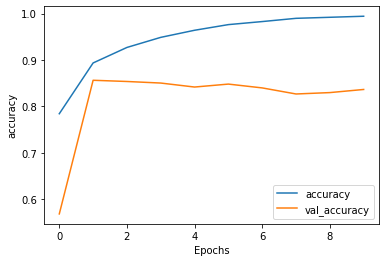

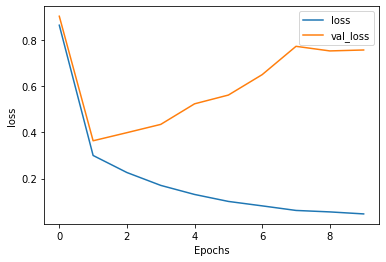

In [92]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [93]:
# Model Definition with BiRNN (GRU)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                9600      
_________________________________________________________________
dense_20 (Dense)             (None, 100)               6500      
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 176,601
Trainable params: 176,401
Non-trainable params: 200
_____________________________________________

In [94]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 24038 samples, validate on 2671 samples
Epoch 1/10
11840/24038 [=============>................] - ETA: 5:15 - loss: 0.9356 - accuracy: 0.51 - ETA: 2:55 - loss: 0.9362 - accuracy: 0.53 - ETA: 2:08 - loss: 0.9451 - accuracy: 0.50 - ETA: 1:44 - loss: 0.9422 - accuracy: 0.51 - ETA: 1:30 - loss: 0.9412 - accuracy: 0.50 - ETA: 1:20 - loss: 0.9421 - accuracy: 0.49 - ETA: 1:13 - loss: 0.9385 - accuracy: 0.49 - ETA: 1:07 - loss: 0.9364 - accuracy: 0.50 - ETA: 1:02 - loss: 0.9321 - accuracy: 0.51 - ETA: 59s - loss: 0.9319 - accuracy: 0.5031 - ETA: 56s - loss: 0.9318 - accuracy: 0.498 - ETA: 54s - loss: 0.9325 - accuracy: 0.496 - ETA: 52s - loss: 0.9308 - accuracy: 0.497 - ETA: 50s - loss: 0.9304 - accuracy: 0.497 - ETA: 49s - loss: 0.9280 - accuracy: 0.504 - ETA: 48s - loss: 0.9276 - accuracy: 0.503 - ETA: 46s - loss: 0.9255 - accuracy: 0.511 - ETA: 44s - loss: 0.9235 - accuracy: 0.516 - ETA: 43s - loss: 0.9229 - accuracy: 0.514 - ETA: 43s - loss: 0.9209 - accuracy: 0.517 - ETA: 42s - l

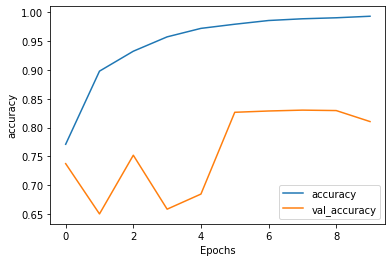

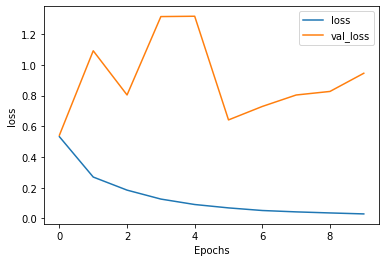

In [95]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

<a name="lstm"></a>
### RNN with LSTM Architecture 

For the prediction of sarcasm of headlines, we will use RNN with the following architectures:

- RNN with Long Short Term Memory Units (with Lasso Regularization, Dropout, Batch Normalization)
- RNN with Long Short Term Memory Units (with Ridge Regularization, Dropout, Batch Normalization)

In [96]:
# Model Definition with BiRNN (LSTM)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                12544     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               6500      
_________________________________________________________________
batch_normalization_9 (Batch (None, 100)               400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 179,545
Trainable params: 179,345
Non-trainable params: 200
_____________________________________________

In [97]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 24038 samples, validate on 2671 samples
Epoch 1/10
11776/24038 [=============>................] - ETA: 4:03 - loss: 2.5781 - accuracy: 0.39 - ETA: 2:12 - loss: 2.5575 - accuracy: 0.45 - ETA: 1:38 - loss: 2.5474 - accuracy: 0.45 - ETA: 1:22 - loss: 2.5317 - accuracy: 0.49 - ETA: 1:11 - loss: 2.5234 - accuracy: 0.48 - ETA: 1:03 - loss: 2.5153 - accuracy: 0.49 - ETA: 57s - loss: 2.5055 - accuracy: 0.5134 - ETA: 53s - loss: 2.4955 - accuracy: 0.517 - ETA: 50s - loss: 2.4857 - accuracy: 0.527 - ETA: 48s - loss: 2.4773 - accuracy: 0.532 - ETA: 46s - loss: 2.4687 - accuracy: 0.536 - ETA: 45s - loss: 2.4608 - accuracy: 0.532 - ETA: 43s - loss: 2.4506 - accuracy: 0.533 - ETA: 42s - loss: 2.4429 - accuracy: 0.532 - ETA: 41s - loss: 2.4341 - accuracy: 0.535 - ETA: 41s - loss: 2.4255 - accuracy: 0.537 - ETA: 40s - loss: 2.4173 - accuracy: 0.536 - ETA: 39s - loss: 2.4075 - accuracy: 0.543 - ETA: 38s - loss: 2.3982 - accuracy: 0.545 - ETA: 38s - loss: 2.3897 - accuracy: 0.546 - ETA: 37s - l

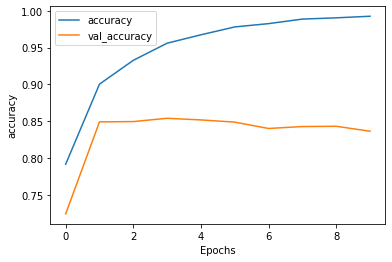

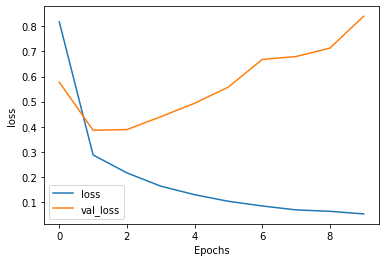

In [98]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [99]:
# Model Definition with BiRNN (LSTM)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 64)                12544     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               6500      
_________________________________________________________________
batch_normalization_10 (Batc (None, 100)               400       
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 101       
Total params: 179,545
Trainable params: 179,345
Non-trainable params: 200
_____________________________________________

In [100]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 24038 samples, validate on 2671 samples
Epoch 1/10
11776/24038 [=============>................] - ETA: 4:38 - loss: 0.9464 - accuracy: 0.42 - ETA: 2:34 - loss: 0.9378 - accuracy: 0.46 - ETA: 1:53 - loss: 0.9391 - accuracy: 0.45 - ETA: 1:33 - loss: 0.9373 - accuracy: 0.45 - ETA: 1:20 - loss: 0.9327 - accuracy: 0.48 - ETA: 1:12 - loss: 0.9303 - accuracy: 0.49 - ETA: 1:05 - loss: 0.9286 - accuracy: 0.48 - ETA: 1:00 - loss: 0.9249 - accuracy: 0.50 - ETA: 57s - loss: 0.9230 - accuracy: 0.4948 - ETA: 54s - loss: 0.9215 - accuracy: 0.500 - ETA: 51s - loss: 0.9194 - accuracy: 0.497 - ETA: 49s - loss: 0.9174 - accuracy: 0.507 - ETA: 48s - loss: 0.9154 - accuracy: 0.515 - ETA: 46s - loss: 0.9132 - accuracy: 0.520 - ETA: 45s - loss: 0.9108 - accuracy: 0.526 - ETA: 44s - loss: 0.9089 - accuracy: 0.532 - ETA: 43s - loss: 0.9069 - accuracy: 0.537 - ETA: 42s - loss: 0.9043 - accuracy: 0.543 - ETA: 41s - loss: 0.9023 - accuracy: 0.547 - ETA: 40s - loss: 0.9006 - accuracy: 0.550 - ETA: 39s - l

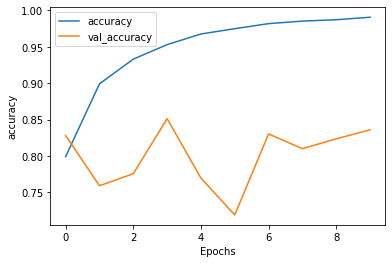

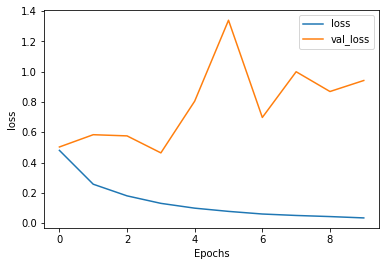

In [101]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [102]:
# Model Definition with CNN (Conv1D)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               12900     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

In [103]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 24038 samples, validate on 2671 samples
Epoch 1/10
24038/24038 [==============================] - ETA: 1:34 - loss: 3.8652 - accuracy: 0.53 - ETA: 18s - loss: 3.7686 - accuracy: 0.5573 - ETA: 12s - loss: 3.6735 - accuracy: 0.578 - ETA: 10s - loss: 3.5998 - accuracy: 0.569 - ETA: 8s - loss: 3.5273 - accuracy: 0.565 - ETA: 8s - loss: 3.4571 - accuracy: 0.55 - ETA: 7s - loss: 3.3865 - accuracy: 0.56 - ETA: 7s - loss: 3.3173 - accuracy: 0.56 - ETA: 6s - loss: 3.2658 - accuracy: 0.56 - ETA: 6s - loss: 3.2157 - accuracy: 0.56 - ETA: 6s - loss: 3.1667 - accuracy: 0.56 - ETA: 6s - loss: 3.1019 - accuracy: 0.56 - ETA: 6s - loss: 3.0375 - accuracy: 0.56 - ETA: 6s - loss: 2.9746 - accuracy: 0.56 - ETA: 5s - loss: 2.9128 - accuracy: 0.57 - ETA: 5s - loss: 2.8522 - accuracy: 0.57 - ETA: 5s - loss: 2.7928 - accuracy: 0.58 - ETA: 5s - loss: 2.7346 - accuracy: 0.58 - ETA: 5s - loss: 2.6763 - accuracy: 0.59 - ETA: 5s - loss: 2.6201 - accuracy: 0.59 - ETA: 5s - loss: 2.5645 - accuracy: 0.60 - E

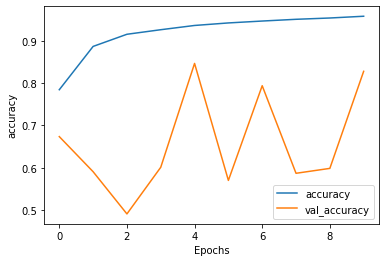

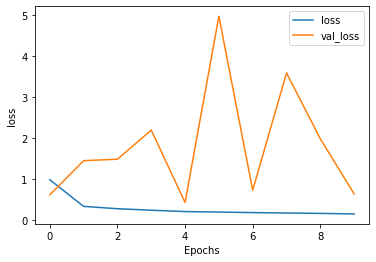

In [104]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

<a name="cnn"></a>
### CNN

For the prediction of sarcasm of headlines, we will use CNN with the following architectures:

- CNN with Conv1D

In [105]:
# Model Definition with CNN (Conv1D)
# with L2 Ridge Regularization
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               12900     
_________________________________________________________________
batch_normalization_12 (Batc (None, 100)               400       
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [106]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 24038 samples, validate on 2671 samples
Epoch 1/10
24038/24038 [==============================] - ETA: 1:28 - loss: 1.0363 - accuracy: 0.54 - ETA: 18s - loss: 1.0215 - accuracy: 0.4974 - ETA: 11s - loss: 1.0060 - accuracy: 0.536 - ETA: 10s - loss: 0.9938 - accuracy: 0.551 - ETA: 8s - loss: 0.9836 - accuracy: 0.534 - ETA: 8s - loss: 0.9725 - accuracy: 0.53 - ETA: 7s - loss: 0.9619 - accuracy: 0.53 - ETA: 7s - loss: 0.9514 - accuracy: 0.54 - ETA: 6s - loss: 0.9407 - accuracy: 0.55 - ETA: 6s - loss: 0.9298 - accuracy: 0.55 - ETA: 6s - loss: 0.9186 - accuracy: 0.56 - ETA: 6s - loss: 0.9078 - accuracy: 0.57 - ETA: 5s - loss: 0.8961 - accuracy: 0.58 - ETA: 5s - loss: 0.8863 - accuracy: 0.59 - ETA: 5s - loss: 0.8733 - accuracy: 0.60 - ETA: 5s - loss: 0.8580 - accuracy: 0.61 - ETA: 5s - loss: 0.8437 - accuracy: 0.62 - ETA: 5s - loss: 0.8316 - accuracy: 0.63 - ETA: 5s - loss: 0.8148 - accuracy: 0.64 - ETA: 5s - loss: 0.8033 - accuracy: 0.64 - ETA: 5s - loss: 0.7932 - accuracy: 0.65 - E

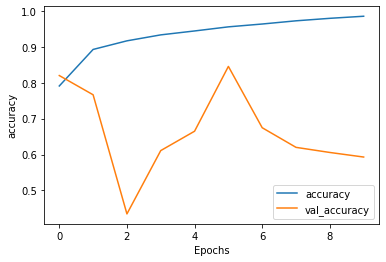

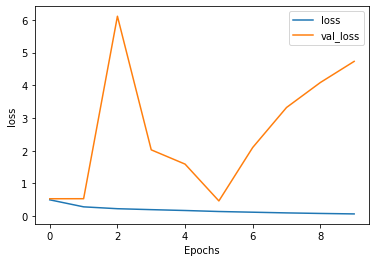

In [107]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

<a name="cnnrnn"></a>
### CNN-RNN combined architecture

For the prediction of sarcasm of headlines, we will use the following architecture:

- Combination of CNN-RNN (LSTM)
   - Output from CNN with Conv1D is used as input for RNN with LSTM (with Lasso Regularization, Dropout)

In [114]:
# Model Definition with CNN (Conv1D)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 1, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding="same"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 120, 128)          2176      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 60, 128)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_34 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

In [115]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Train on 24038 samples, validate on 2671 samples
Epoch 1/20
11776/24038 [=============>................] - ETA: 4:45 - loss: 3.8325 - accuracy: 0.48 - ETA: 2:32 - loss: 3.8160 - accuracy: 0.47 - ETA: 1:49 - loss: 3.8000 - accuracy: 0.45 - ETA: 1:30 - loss: 3.7839 - accuracy: 0.45 - ETA: 1:17 - loss: 3.7678 - accuracy: 0.46 - ETA: 1:08 - loss: 3.7518 - accuracy: 0.46 - ETA: 1:02 - loss: 3.7359 - accuracy: 0.47 - ETA: 57s - loss: 3.7200 - accuracy: 0.4863 - ETA: 53s - loss: 3.7044 - accuracy: 0.482 - ETA: 49s - loss: 3.6886 - accuracy: 0.492 - ETA: 47s - loss: 3.6728 - accuracy: 0.497 - ETA: 45s - loss: 3.6572 - accuracy: 0.505 - ETA: 43s - loss: 3.6416 - accuracy: 0.508 - ETA: 42s - loss: 3.6262 - accuracy: 0.507 - ETA: 41s - loss: 3.6108 - accuracy: 0.509 - ETA: 40s - loss: 3.5955 - accuracy: 0.512 - ETA: 39s - loss: 3.5802 - accuracy: 0.511 - ETA: 38s - loss: 3.5650 - accuracy: 0.510 - ETA: 37s - loss: 3.5497 - accuracy: 0.514 - ETA: 36s - loss: 3.5346 - accuracy: 0.516 - ETA: 35s - l

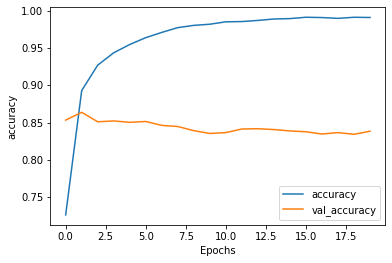

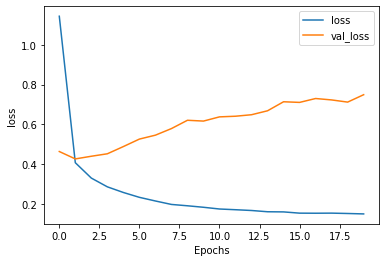

In [116]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()



plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

# References:
[1] Using LDA for topic extraction: https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

[2] Guidelines for the use of LDA: https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

[3] Topic modelling in python with nltk and gensim: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

# Kaggle Link:
https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/kernels